# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Time series libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# 2. Data

In [2]:
df = pd.read_csv("BNI_Preprocessed_Data", index_col='Date', parse_dates=True)
df.index.freq = 'D'

df.head()

,Open,High,Low,Volume,Adj Close,Close
Date,,,,,,
2016-01-04,4990.0,5025.000000,4885.0,1366.0,4102.94,4890.0
2016-01-05,4890.0,4975.000000,4890.0,2646.0,4153.28,4950.0
2016-01-06,4960.0,5097.632333,4935.0,3638.0,4237.19,5050.0
2016-01-07,5000.0,5092.812785,4985.0,1865.0,4182.65,4985.0
2016-01-08,5000.0,5050.000000,4975.0,2435.0,4195.24,5000.0


In [3]:
len(df)

2004

# 3. Open Stock Price

### - Plot

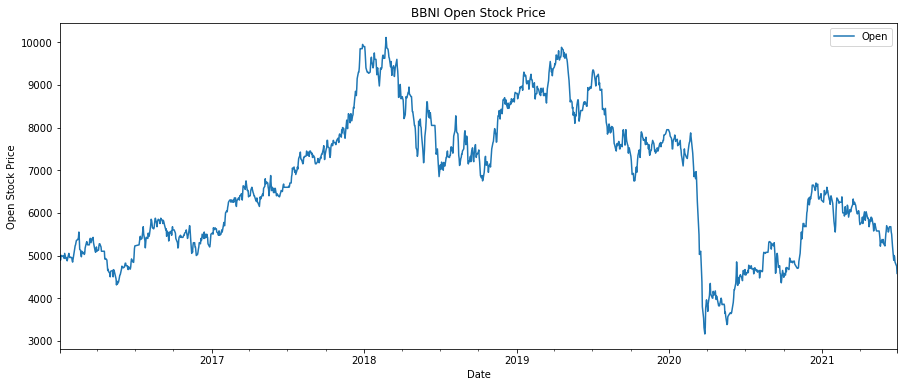

In [4]:
df[['Open']].plot(figsize=(15,6), title='BBNI Open Stock Price', ylabel='Open Stock Price');

### - Check Stationary Data

In [5]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [6]:
# Cek stationary data open stock price
adfuller_test(df['Open'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.495458
p-value                    0.535757
# lags used                2.000000
# observations          2001.000000
critical value (1%)       -3.433622
critical value (5%)       -2.862985
critical value (10%)      -2.567540

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


Data tidak stationer, maka dilakukan differencing agar data stationer

### - Differencing

In [7]:
# differencing
df['Open d1'] = diff(df['Open'], k_diff=1)     #lag 1

# Cek stationary data open stock price dengan differencing lag 1
adfuller_test(df['Open d1'])

Augmented Dickey-Fuller Test:
ADF test statistic       -28.150439
p-value                    0.000000
# lags used                1.000000
# observations          2001.000000
critical value (1%)       -3.433622
critical value (5%)       -2.862985
critical value (10%)      -2.567540

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data open stock price akan digunakan parameter differencing ARIMA d=1. 

### - Seasonality Data

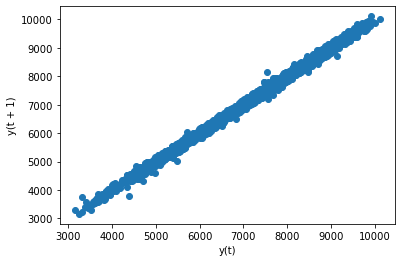

In [8]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Open']);

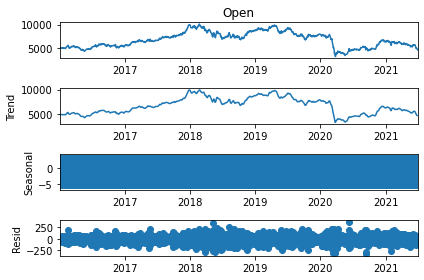

In [9]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Open'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data open stock price, sehingga akan digunakan model ARIMA. 

### - Autoregression (AR) Parameter

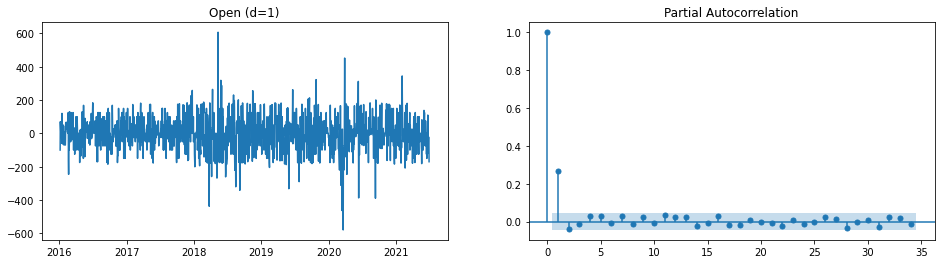

In [10]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Open'].diff().dropna())
ax1.set_title('Open (d=1)')
plot_pacf(df['Open'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 2

### - Moving Average (MA) Parameter

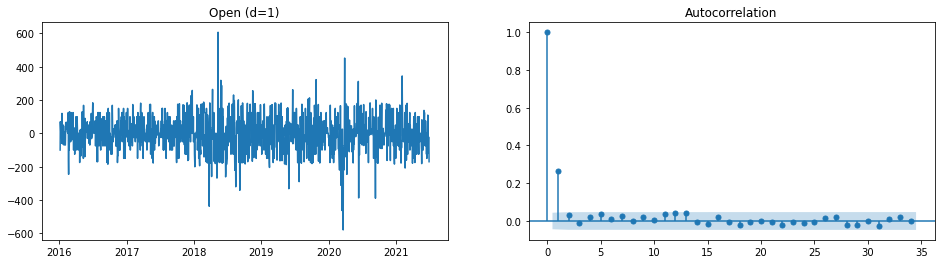

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Open'].diff().dropna())
ax1.set_title('Open (d=1)')
plot_acf(df['Open'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 0

### - Split Data

In [12]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [13]:
ARIMA_open = ARIMA(train_data['Open'], order=(2,1,0)).fit()
ARIMA_open.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                 1944
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -11453.148
Date:                Sun, 12 Dec 2021   AIC                          22912.295
Time:                        09:53:01   BIC                          22929.011
Sample:                    01-04-2016   HQIC                         22918.442
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2728      0.018     15.579      0.000       0.239       0.307
ar.L2         -0.0410      0.021     -1.997      0.046      -0.081      -0.001
sigma2      7714.4730    172.761     44.654      0.000    7375.868    8053.078
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               515.36
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.06   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [14]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_open.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,0) Test Prediction')
prediction_test

2021-05-01    5876.025252
2021-05-02    5876.304978
2021-05-03    5876.339252
2021-05-04    5876.337132
2021-05-05    5876.335148
2021-05-06    5876.334693
2021-05-07    5876.334651
2021-05-08    5876.334658
2021-05-09    5876.334661
2021-05-10    5876.334662
2021-05-11    5876.334662
2021-05-12    5876.334662
2021-05-13    5876.334662
2021-05-14    5876.334662
2021-05-15    5876.334662
2021-05-16    5876.334662
2021-05-17    5876.334662
2021-05-18    5876.334662
2021-05-19    5876.334662
2021-05-20    5876.334662
2021-05-21    5876.334662
2021-05-22    5876.334662
2021-05-23    5876.334662
2021-05-24    5876.334662
2021-05-25    5876.334662
2021-05-26    5876.334662
2021-05-27    5876.334662
2021-05-28    5876.334662
2021-05-29    5876.334662
2021-05-30    5876.334662
2021-05-31    5876.334662
2021-06-01    5876.334662
2021-06-02    5876.334662
2021-06-03    5876.334662
2021-06-04    5876.334662
2021-06-05    5876.334662
2021-06-06    5876.334662
2021-06-07    5876.334662
2021-06-08  

### - Model Evaluation

In [15]:
# rmse
error_rmse = rmse(test_data['Open'], prediction_test)
print(f'ARIMA(2,1,0) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Open'], prediction_test)
print(f'ARIMA(2,1,0) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_open.aic
print(f'ARIMA(2,1,0) AIC: {aic_values:6.5}')

ARIMA(2,1,0) RMSE Error: 560.9457697
ARIMA(2,1,0) MAE Error: 473.1877039
ARIMA(2,1,0) AIC: 2.2912e+04


In [16]:
# perbandingan rata-rata open stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata Open stock price actual:", test_data['Open'].mean())
print("Rata-rata Open stock price predicted:", prediction_test.mean())

Rata-rata Open stock price actual: 5403.141432761232
Rata-rata Open stock price predicted: 5876.329136649272


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset.

### - ARIMA Model on Full Dataset

In [17]:
ARIMA_open = ARIMA(df['Open'], order=(2,1,0)).fit()
ARIMA_open.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                 2004
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -11796.515
Date:                Sun, 12 Dec 2021   AIC                          23599.030
Time:                        09:53:01   BIC                          23615.837
Sample:                    01-04-2016   HQIC                         23605.201
                         - 06-29-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2756      0.017     15.998      0.000       0.242       0.309
ar.L2         -0.0394      0.020     -1.945      0.052      -0.079       0.000
sigma2      7635.4514    168.536     45.305      0.000    7305.127    7965.776
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               516.73
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value
Predict open stock price for the next 6 months

In [18]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_open.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,0) Open Stock Price Forecast')
forecast

2021-06-30    4534.072206
2021-07-01    4528.111066
2021-07-02    4528.277142
2021-07-03    4528.557676
2021-07-04    4528.628441
                 ...     
2021-12-24    4528.635859
2021-12-25    4528.635859
2021-12-26    4528.635859
2021-12-27    4528.635859
2021-12-28    4528.635859
Freq: D, Name: ARIMA(2,1,0) Open Stock Price Forecast, Length: 182, dtype: float64

In [19]:
# save model
ARIMA_open.save('model_bni_open.pkl')
# load model
# ARIMA_open = ARIMAResults.load('model_bni_open.pkl')

# 4. High Stock Price Model

### - Plot

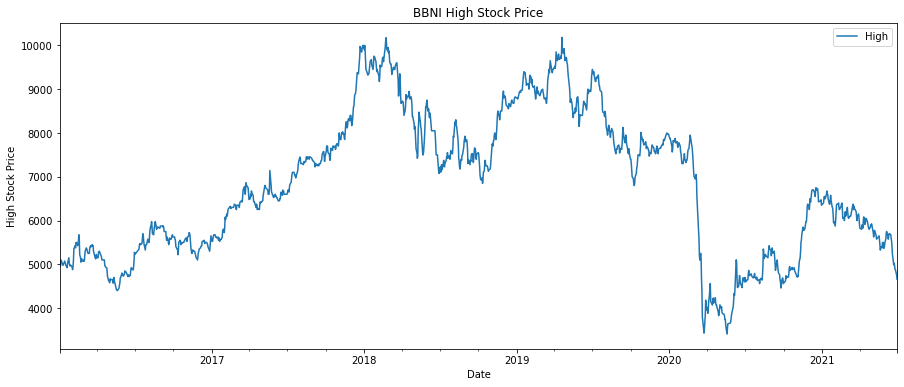

In [20]:
df[['High']].plot(figsize=(15,6), title='BBNI High Stock Price', ylabel='High Stock Price');

### - Check Stationary Data

In [21]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [22]:
# Cek stationary data high stock price
adfuller_test(df['High'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.578238
p-value                    0.494516
# lags used                5.000000
# observations          1998.000000
critical value (1%)       -3.433627
critical value (5%)       -2.862988
critical value (10%)      -2.567541

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


Data tidak stationer, maka dilakukan differencing agar data stationer

### - Differencing

In [23]:
# differencing
df['High d1'] = diff(df['High'], k_diff=1)     #lag 1

# Cek stationary data high stock price dengan differencing lag 1
adfuller_test(df['High d1'])

Augmented Dickey-Fuller Test:
ADF test statistic     -1.780627e+01
p-value                 3.202808e-30
# lags used             4.000000e+00
# observations          1.998000e+03
critical value (1%)    -3.433627e+00
critical value (5%)    -2.862988e+00
critical value (10%)   -2.567541e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data high stock price akan digunakan parameter differencing ARIMA d=1

### - Seasonality Data

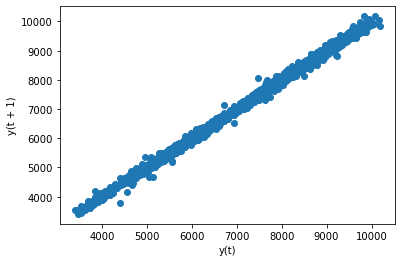

In [24]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['High']);

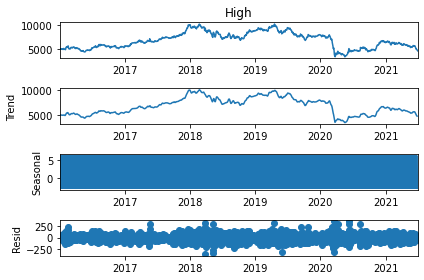

In [25]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['High'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data high stock price, sehingga akan digunakan model ARIMA. 

### - Autoregression (AR) Parameter

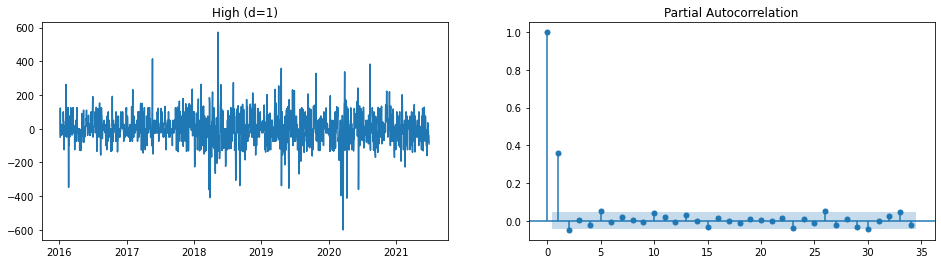

In [26]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['High'].diff().dropna())
ax1.set_title('High (d=1)')
plot_pacf(df['High'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 2

### - Moving Average (MA) Parameter

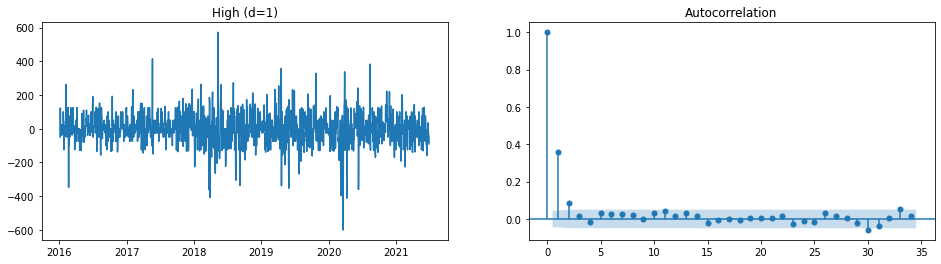

In [27]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['High'].diff().dropna())
ax1.set_title('High (d=1)')
plot_acf(df['High'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 2

### - Split Data

In [28]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [29]:
ARIMA_high = ARIMA(train_data['High'], order=(2,1,2)).fit()
ARIMA_high.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                 1944
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -11226.247
Date:                Sun, 12 Dec 2021   AIC                          22462.495
Time:                        09:53:05   BIC                          22490.355
Sample:                    01-04-2016   HQIC                         22472.739
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4216      0.355     -1.187      0.235      -1.118       0.275
ar.L2          0.2057      0.061      3.357      0.001       0.086       0.326
ma.L1          0.7985      0.356      2.244      0.025       0.101       1.496
ma.L2          0.0362      0.104      0.348      0.728      -0.168       0.240
sigma2      6116.9823    104.226     58.690      0.000    5912.703    6321.261
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2208.54
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [30]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_high.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,2) Test Prediction')
prediction_test

2021-05-01    5853.760978
2021-05-02    5850.234882
2021-05-03    5847.352390
2021-05-04    5847.842242
2021-05-05    5847.042783
2021-05-06    5847.480583
2021-05-07    5847.131562
2021-05-08    5847.368760
2021-05-09    5847.196966
2021-05-10    5847.318184
2021-05-11    5847.231742
2021-05-12    5847.293119
2021-05-13    5847.249462
2021-05-14    5847.280493
2021-05-15    5847.258431
2021-05-16    5847.274115
2021-05-17    5847.262964
2021-05-18    5847.270891
2021-05-19    5847.265256
2021-05-20    5847.269262
2021-05-21    5847.266414
2021-05-22    5847.268439
2021-05-23    5847.266999
2021-05-24    5847.268023
2021-05-25    5847.267295
2021-05-26    5847.267812
2021-05-27    5847.267445
2021-05-28    5847.267706
2021-05-29    5847.267520
2021-05-30    5847.267652
2021-05-31    5847.267559
2021-06-01    5847.267625
2021-06-02    5847.267578
2021-06-03    5847.267612
2021-06-04    5847.267588
2021-06-05    5847.267605
2021-06-06    5847.267593
2021-06-07    5847.267601
2021-06-08  

### - Model Evaluation

In [31]:
# rmse
error_rmse = rmse(test_data['High'], prediction_test)
print(f'ARIMA(2,1,2) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['High'], prediction_test)
print(f'ARIMA(2,1,2) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_high.aic
print(f'ARIMA(2,1,2) AIC: {aic_values:6.5}')

ARIMA(2,1,2) RMSE Error: 487.3577048
ARIMA(2,1,2) MAE Error: 388.0638894
ARIMA(2,1,2) AIC: 2.2462e+04


In [32]:
# perbandingan rata-rata high stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata High stock price actual:", test_data['High'].mean())
print("Rata-rata High stock price predicted:", prediction_test.mean())

Rata-rata High stock price actual: 5459.370915237384
Rata-rata High stock price predicted: 5847.434804605331


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset.

### - ARIMA Model on Full Dataset

In [33]:
ARIMA_high = ARIMA(df['High'], order=(2,1,2)).fit()
ARIMA_high.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                 2004
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -11560.323
Date:                Sun, 12 Dec 2021   AIC                          23130.647
Time:                        09:53:06   BIC                          23158.659
Sample:                    01-04-2016   HQIC                         23140.931
                         - 06-29-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4220      0.364     -1.159      0.247      -1.136       0.292
ar.L2          0.2073      0.065      3.212      0.001       0.081       0.334
ma.L1          0.8001      0.365      2.194      0.028       0.085       1.515
ma.L2          0.0378      0.103      0.368      0.713      -0.163       0.239
sigma2      6040.1801    101.426     59.552      0.000    5841.388    6238.972
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2254.85
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value
Predict high stock price for the next 6 months

In [34]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_high.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,2) High Stock Price Forecast')
forecast

2021-06-30    4627.922003
2021-07-01    4619.975544
2021-07-02    4616.680444
2021-07-03    4616.423937
2021-07-04    4615.849260
                 ...     
2021-12-24    4615.907074
2021-12-25    4615.907074
2021-12-26    4615.907074
2021-12-27    4615.907074
2021-12-28    4615.907074
Freq: D, Name: ARIMA(2,1,2) High Stock Price Forecast, Length: 182, dtype: float64

In [35]:
# save model
ARIMA_high.save('model_bni_high.pkl')

# 5. Low Stock Price Model

### - Plot

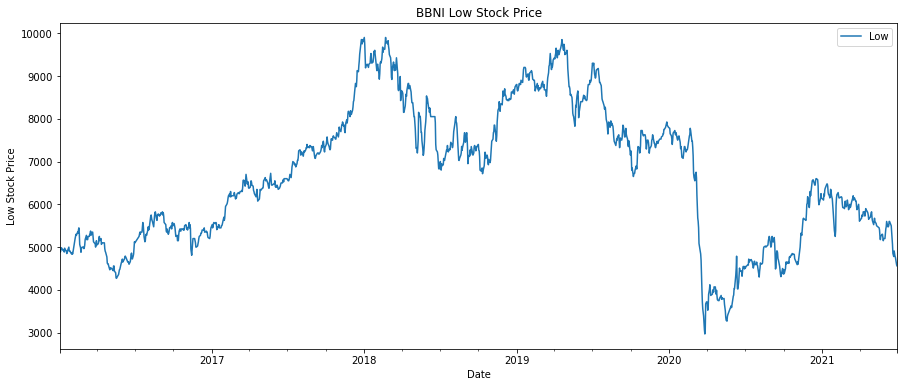

In [36]:
df[['Low']].plot(figsize=(15,6), title='BBNI Low Stock Price', ylabel='Low Stock Price');

### - Check Stationary Data

In [37]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [38]:
# Cek stationary data low stock price
adfuller_test(df['Low'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.668327
p-value                    0.447501
# lags used                6.000000
# observations          1997.000000
critical value (1%)       -3.433629
critical value (5%)       -2.862988
critical value (10%)      -2.567541

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


Data tidak stationer, maka dilakukan differencing agar data stationer

### - Differencing

In [39]:
# differencing
df['Low d1'] = diff(df['Low'], k_diff=1)     #lag 1

# Cek stationary data low stock price dengan differencing lag 1
adfuller_test(df['Low d1'])

Augmented Dickey-Fuller Test:
ADF test statistic     -1.646378e+01
p-value                 2.317025e-29
# lags used             5.000000e+00
# observations          1.997000e+03
critical value (1%)    -3.433629e+00
critical value (5%)    -2.862988e+00
critical value (10%)   -2.567541e+00

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data low stock price akan digunakan parameter differencing ARIMA d=1 

### - Seasonality Data

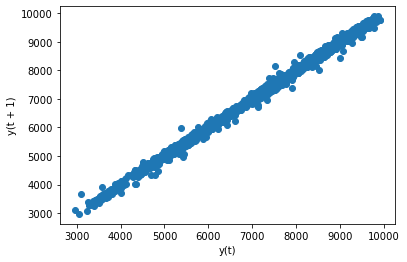

In [40]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Low']);

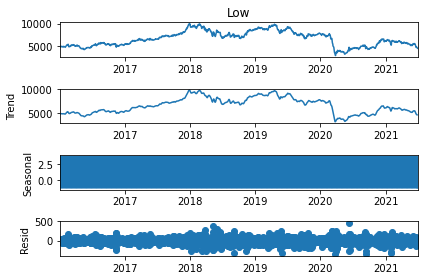

In [41]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Low'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data low stock price, sehingga akan digunakan model ARIMA. 

### - Autoregression (AR) Parameter

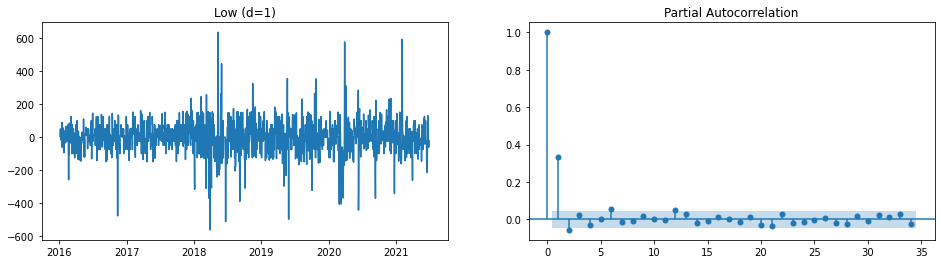

In [42]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Low'].diff().dropna())
ax1.set_title('Low (d=1)')
plot_pacf(df['Low'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 2

### - Moving Average (MA) Parameter

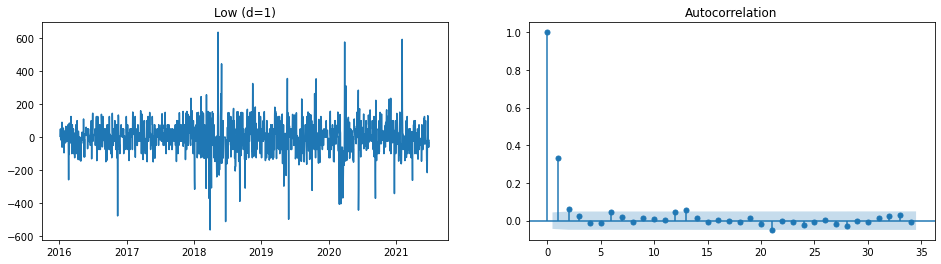

In [43]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Low'].diff().dropna())
ax1.set_title('Low (d=1)')
plot_acf(df['Low'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 2

### - Split Data

In [44]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [45]:
ARIMA_low = ARIMA(train_data['Low'], order=(2,1,2)).fit()
ARIMA_low.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Low   No. Observations:                 1944
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -11373.273
Date:                Sun, 12 Dec 2021   AIC                          22756.546
Time:                        09:53:10   BIC                          22784.406
Sample:                    01-04-2016   HQIC                         22766.791
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0588      1.491      0.039      0.969      -2.863       2.981
ar.L2          0.0603      0.238      0.253      0.800      -0.407       0.527
ma.L1          0.2905      1.489      0.195      0.845      -2.627       3.208
ma.L2         -0.0270      0.302     -0.089      0.929      -0.619       0.565
sigma2      7107.9132    112.750     63.041      0.000    6886.926    7328.900
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3900.54
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [46]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_low.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,2) Test Prediction')
prediction_test

2021-05-01    5644.273154
2021-05-02    5637.221390
2021-05-03    5633.950470
2021-05-04    5633.332673
2021-05-05    5633.098978
2021-05-06    5633.047961
2021-05-07    5633.030860
2021-05-08    5633.026776
2021-05-09    5633.025504
2021-05-10    5633.025183
2021-05-11    5633.025087
2021-05-12    5633.025062
2021-05-13    5633.025055
2021-05-14    5633.025053
2021-05-15    5633.025052
2021-05-16    5633.025052
2021-05-17    5633.025052
2021-05-18    5633.025052
2021-05-19    5633.025052
2021-05-20    5633.025052
2021-05-21    5633.025052
2021-05-22    5633.025052
2021-05-23    5633.025052
2021-05-24    5633.025052
2021-05-25    5633.025052
2021-05-26    5633.025052
2021-05-27    5633.025052
2021-05-28    5633.025052
2021-05-29    5633.025052
2021-05-30    5633.025052
2021-05-31    5633.025052
2021-06-01    5633.025052
2021-06-02    5633.025052
2021-06-03    5633.025052
2021-06-04    5633.025052
2021-06-05    5633.025052
2021-06-06    5633.025052
2021-06-07    5633.025052
2021-06-08  

### - Model Evaluation

In [47]:
# rmse
error_rmse = rmse(test_data['Low'], prediction_test)
print(f'ARIMA(2,1,2) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Low'], prediction_test)
print(f'ARIMA(2,1,2) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_low.aic
print(f'ARIMA(2,1,2) AIC: {aic_values:6.5}')

ARIMA(2,1,2) RMSE Error:  447.015374
ARIMA(2,1,2) MAE Error: 332.0885705
ARIMA(2,1,2) AIC: 2.2757e+04


In [48]:
# perbandingan rata-rata low stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata Low stock price actual:", test_data['Low'].mean())
print("Rata-rata Low stock price predicted:", prediction_test.mean())

Rata-rata Low stock price actual: 5302.614590816695
Rata-rata Low stock price predicted: 5633.304759995228


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset. 

### - ARIMA Model on Full Dataset

In [49]:
ARIMA_low = ARIMA(df['Low'], order=(2,1,2)).fit()
ARIMA_low.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Low   No. Observations:                 2004
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -11710.248
Date:                Sun, 12 Dec 2021   AIC                          23430.495
Time:                        09:53:12   BIC                          23458.507
Sample:                    01-04-2016   HQIC                         23440.780
                         - 06-29-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0493      1.434      0.034      0.973      -2.761       2.860
ar.L2          0.0644      0.241      0.267      0.790      -0.409       0.538
ma.L1          0.3026      1.432      0.211      0.833      -2.504       3.109
ma.L2         -0.0242      0.282     -0.086      0.931      -0.577       0.528
sigma2      6997.8018    109.003     64.198      0.000    6784.160    7211.443
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4022.13
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.41   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value
Predict low stock price for the next 6 months

In [50]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_low.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,2) Low Stock Price Forecast')
forecast

2021-06-30    4555.751896
2021-07-01    4554.287832
2021-07-02    4553.942025
2021-07-03    4553.830669
2021-07-04    4553.802905
                 ...     
2021-12-24    4553.791249
2021-12-25    4553.791249
2021-12-26    4553.791249
2021-12-27    4553.791249
2021-12-28    4553.791249
Freq: D, Name: ARIMA(2,1,2) Low Stock Price Forecast, Length: 182, dtype: float64

In [51]:
# save model
ARIMA_low.save('model_bni_low.pkl')

# 6. Stock Volume Model

### - Plot

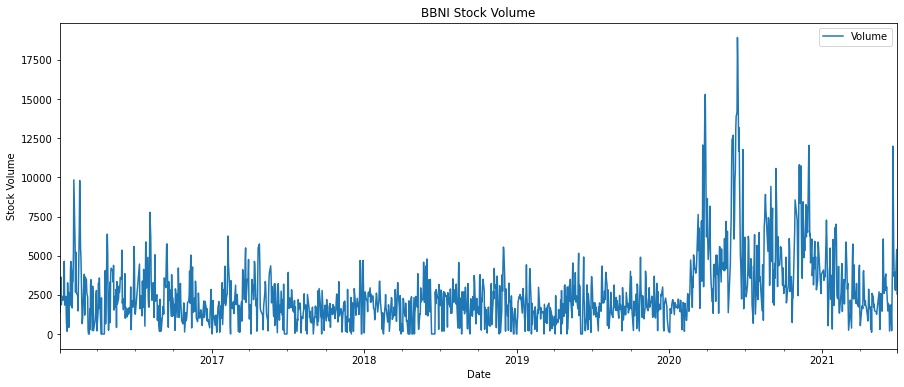

In [52]:
df[['Volume']].plot(figsize=(15,6), title='BBNI Stock Volume', ylabel='Stock Volume');

### - Check Stationarity Data

In [53]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [54]:
# Cek stationary data stock volume
adfuller_test(df['Volume'])

Augmented Dickey-Fuller Test:
ADF test statistic        -5.178847
p-value                    0.000010
# lags used               14.000000
# observations          1989.000000
critical value (1%)       -3.433642
critical value (5%)       -2.862994
critical value (10%)      -2.567544

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data stock volume sudah stationer, maka tidak perlu dilakukan differencing. Dari informasi ini, untuk data volume stock akan digunakan parameter differencing ARIMA d=0. 

### - Seasonality Data

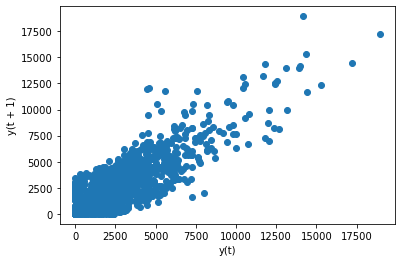

In [55]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Volume']);

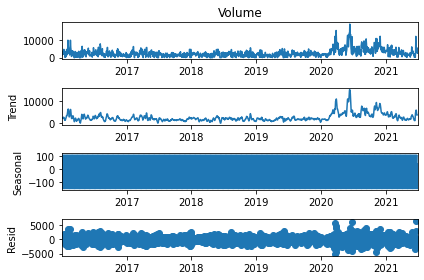

In [56]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Volume'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data open stock price, sehingga akan digunakan model ARIMA. 

### - Autoregression (AR) Parameter

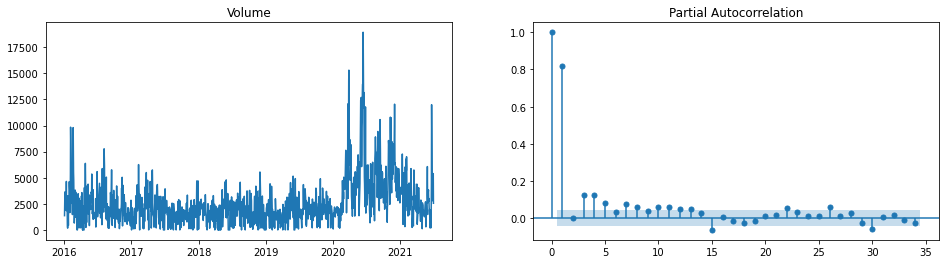

In [57]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Volume'].dropna())
ax1.set_title('Volume')
plot_pacf(df['Volume'].dropna(), ax=ax2);

### - Moving Avarage (MA) Parameter

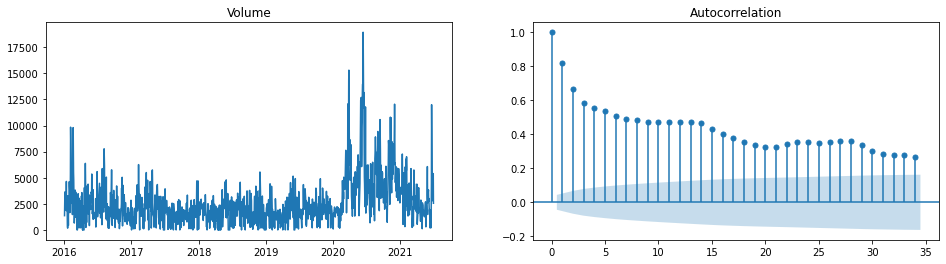

In [58]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Volume'].dropna())
ax1.set_title('Volume')
plot_acf(df['Volume'].dropna(), ax=ax2);

Jika PACF dari deret yang berbeda menampilkan cutoff yang tajam atau autokorelasi lag-1 positif, sedangkan ACF meluruh lebih lambat, maka pertimbangkan untuk menambahkan suku AR ke model. Artinya pola autokorelasi dapat dijelaskan lebih mudah dengan menambahkan suku AR daripada menambahkan suku MA. Jeda di mana PACF terputus menunjukkan jumlah istilah AR. Karena AR menunjukkan autokorelasi lag-1 positif, maka akan digunakan p = 1, q = 0. 

### - Split Data

In [59]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [60]:
ARIMA_volume = ARIMA(train_data['Volume'], order=(1,0,0)).fit()
ARIMA_volume.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Volume   No. Observations:                 1944
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -16554.695
Date:                Sun, 12 Dec 2021   AIC                          33115.389
Time:                        09:53:14   BIC                          33132.107
Sample:                    01-04-2016   HQIC                         33121.536
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2530.5932    170.503     14.842      0.000    2196.414    2864.773
ar.L1          0.8192      0.009     93.866      0.000       0.802       0.836
sigma2      1.459e+06   3.13e+04     46.560      0.000     1.4e+06    1.52e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               894.40
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [61]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_volume.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,0,0) Test Prediction')
prediction_test

2021-05-01    2580.076816
2021-05-02    2571.128840
2021-05-03    2563.798901
2021-05-04    2557.794414
2021-05-05    2552.875701
2021-05-06    2548.846426
2021-05-07    2545.545752
2021-05-08    2542.841930
2021-05-09    2540.627033
2021-05-10    2538.812649
2021-05-11    2537.326355
2021-05-12    2536.108823
2021-05-13    2535.111454
2021-05-14    2534.294437
2021-05-15    2533.625158
2021-05-16    2533.076904
2021-05-17    2532.627788
2021-05-18    2532.259885
2021-05-19    2531.958509
2021-05-20    2531.711629
2021-05-21    2531.509393
2021-05-22    2531.343726
2021-05-23    2531.208016
2021-05-24    2531.096846
2021-05-25    2531.005779
2021-05-26    2530.931179
2021-05-27    2530.870069
2021-05-28    2530.820009
2021-05-29    2530.779001
2021-05-30    2530.745409
2021-05-31    2530.717891
2021-06-01    2530.695349
2021-06-02    2530.676883
2021-06-03    2530.661757
2021-06-04    2530.649365
2021-06-05    2530.639215
2021-06-06    2530.630900
2021-06-07    2530.624088
2021-06-08  

### - Model Evaluation

In [62]:
# rmse
error_rmse = rmse(test_data['Volume'], prediction_test)
print(f'ARIMA(1,0,0) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Volume'], prediction_test)
print(f'ARIMA(1,0,0) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_volume.aic
print(f'ARIMA(1,0,0) AIC: {aic_values:6.5}')

ARIMA(1,0,0) RMSE Error: 1902.266594
ARIMA(1,0,0) MAE Error: 1188.573214
ARIMA(1,0,0) AIC: 3.3115e+04


In [63]:
# perbandingan rata-rata stock volume 2 bulan kedepan antara predicted dan actual
print("Rata-rata stock Volume actual:", test_data['Volume'].mean())
print("Rata-rata stock Volume predicted:", prediction_test.mean())

Rata-rata stock Volume actual: 2703.183076855262
Rata-rata stock Volume predicted: 2535.1540568417745


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset. 

### - ARIMA Model on Full Dataset

In [64]:
ARIMA_volume = ARIMA(df['Volume'], order=(1,0,0)).fit()
ARIMA_volume.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Volume   No. Observations:                 2004
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -17075.904
Date:                Sun, 12 Dec 2021   AIC                          34157.809
Time:                        09:53:14   BIC                          34174.617
Sample:                    01-04-2016   HQIC                         34163.980
                         - 06-29-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2535.7606    167.525     15.137      0.000    2207.418    2864.103
ar.L1          0.8160      0.009     93.531      0.000       0.799       0.833
sigma2      1.474e+06   2.97e+04     49.688      0.000    1.42e+06    1.53e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1334.63
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                             0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value
Predict stock volume price for the next 6 months

In [65]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_volume.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,0,0) Stock Volume Forecast')
forecast

2021-06-30    2549.827498
2021-07-01    2547.238820
2021-07-02    2545.126526
2021-07-03    2543.402949
2021-07-04    2541.996556
                 ...     
2021-12-24    2535.760592
2021-12-25    2535.760592
2021-12-26    2535.760592
2021-12-27    2535.760592
2021-12-28    2535.760592
Freq: D, Name: ARIMA(1,0,0) Stock Volume Forecast, Length: 182, dtype: float64

In [66]:
# save model
ARIMA_volume.save('model_bni_volume.pkl')

# 7. Adj. Close Stock Price Model

### - Plot

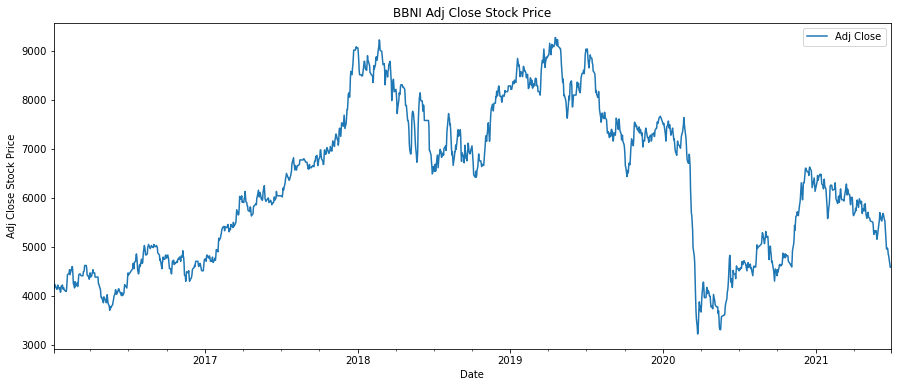

In [67]:
df[['Adj Close']].plot(figsize=(15,6), title='BBNI Adj Close Stock Price', ylabel='Adj Close Stock Price');

### - Check Stationarity Data

In [68]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [69]:
# Cek stationary data adj close stock price
adfuller_test(df['Adj Close'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.761369
p-value                    0.399802
# lags used                3.000000
# observations          2000.000000
critical value (1%)       -3.433624
critical value (5%)       -2.862986
critical value (10%)      -2.567540

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


Data tidak stationer, maka dilakukan differencing agar data stationer

### - Differencing

In [70]:
# differencing
df['Adj Close d1'] = diff(df['Adj Close'], k_diff=1)     #lag 1

# Cek stationary data adj close stock price dengan differencing lag 1
adfuller_test(df['Adj Close d1'])

Augmented Dickey-Fuller Test:
ADF test statistic       -22.596116
p-value                    0.000000
# lags used                2.000000
# observations          2000.000000
critical value (1%)       -3.433624
critical value (5%)       -2.862986
critical value (10%)      -2.567540

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data adj close stock price akan digunakan parameter differencing ARIMA d=1 

### - Seasonality Data

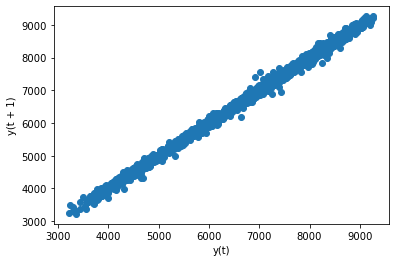

In [71]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Adj Close']);

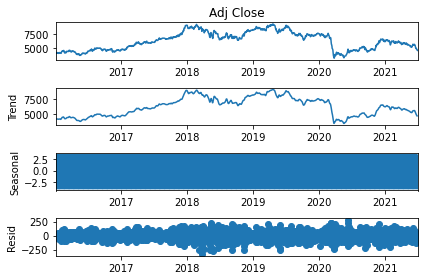

In [72]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Adj Close'].dropna(), model='additive')
result.plot();

Dengan menggunakan plot lag dan plot ETS, didapatkan informasi bahwa tidak terdapat seasonality pada data open stock price, sehingga akan digunakan model ARIMA. 

### - Autoregression (AR) Parameter

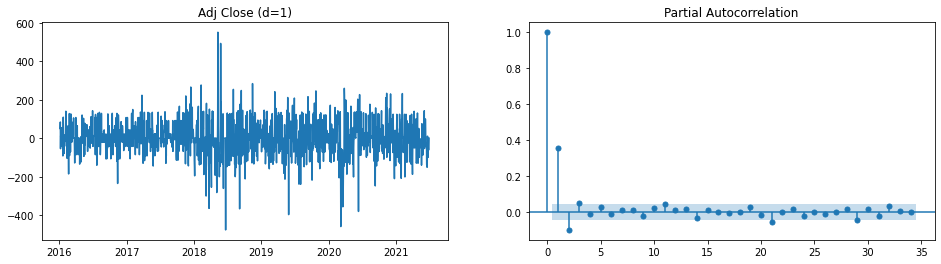

In [73]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Adj Close'].diff().dropna())
ax1.set_title('Adj Close (d=1)')
plot_pacf(df['Adj Close'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 3

### - Moving Average (MA) Parameter

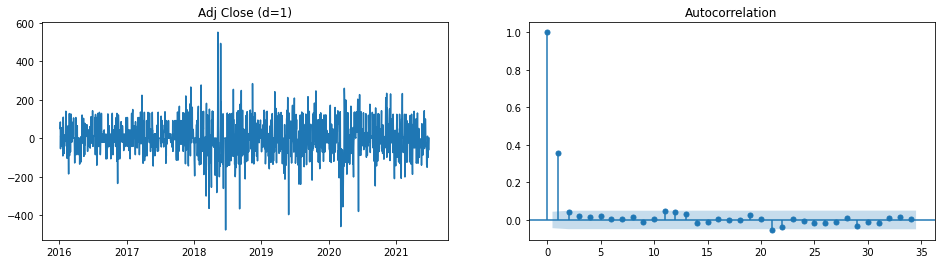

In [74]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Adj Close'].diff().dropna())
ax1.set_title('Adj Close (d=1)')
plot_acf(df['Adj Close'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 1 

### - Split Data

In [75]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [76]:
ARIMA_adjclose = ARIMA(train_data['Adj Close'], order=(3,1,1)).fit()
ARIMA_adjclose.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1944
Model:                 ARIMA(3, 1, 1)   Log Likelihood              -11210.432
Date:                Sun, 12 Dec 2021   AIC                          22430.865
Time:                        09:53:17   BIC                          22458.724
Sample:                    01-04-2016   HQIC                         22441.109
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.306     -0.414      0.679      -0.727       0.473
ar.L2          0.0839      0.126      0.665      0.506      -0.164       0.331
ar.L3         -0.0073      0.046     -0.158      0.875      -0.098       0.084
ma.L1          0.5218      0.305      1.711      0.087      -0.076       1.120
sigma2      6015.9327    131.603     45.713      0.000    5757.996    6273.869
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               687.07
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [77]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_adjclose.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(3,1,1) Test Prediction')
prediction_test

2021-05-01    5681.378693
2021-05-02    5678.151038
2021-05-03    5674.181100
2021-05-04    5674.878472
2021-05-05    5674.480464
2021-05-06    5674.618514
2021-05-07    5674.562501
2021-05-08    5674.584103
2021-05-09    5674.575652
2021-05-10    5674.578946
2021-05-11    5674.577661
2021-05-12    5674.578163
2021-05-13    5674.577967
2021-05-14    5674.578043
2021-05-15    5674.578014
2021-05-16    5674.578025
2021-05-17    5674.578021
2021-05-18    5674.578022
2021-05-19    5674.578022
2021-05-20    5674.578022
2021-05-21    5674.578022
2021-05-22    5674.578022
2021-05-23    5674.578022
2021-05-24    5674.578022
2021-05-25    5674.578022
2021-05-26    5674.578022
2021-05-27    5674.578022
2021-05-28    5674.578022
2021-05-29    5674.578022
2021-05-30    5674.578022
2021-05-31    5674.578022
2021-06-01    5674.578022
2021-06-02    5674.578022
2021-06-03    5674.578022
2021-06-04    5674.578022
2021-06-05    5674.578022
2021-06-06    5674.578022
2021-06-07    5674.578022
2021-06-08  

### - Model Evaluation

In [78]:
# rmse
error_rmse = rmse(test_data['Adj Close'], prediction_test)
print(f'ARIMA(3,1,1) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Adj Close'], prediction_test)
print(f'ARIMA(3,1,1) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_adjclose.aic
print(f'ARIMA(3,1,1) AIC: {aic_values:6.5}')

ARIMA(3,1,1) RMSE Error: 443.0744429
ARIMA(3,1,1) MAE Error: 321.4672821
ARIMA(3,1,1) AIC: 2.2431e+04


In [79]:
# perbandingan rata-rata adjusted close stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata Adjusted Close stock price actual:", test_data['Adj Close'].mean())
print("Rata-rata Adjusted Close stock price predicted:", prediction_test.mean())

Rata-rata Adjusted Close stock price actual: 5354.773754598068
Rata-rata Adjusted Close stock price predicted: 5674.7481720363385


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset. 

### - ARIMA Model on Full Dataset

In [80]:
ARIMA_adjclose = ARIMA(df['Adj Close'], order=(3,1,1)).fit()
ARIMA_adjclose.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2004
Model:                 ARIMA(3, 1, 1)   Log Likelihood              -11541.945
Date:                Sun, 12 Dec 2021   AIC                          23093.890
Time:                        09:53:18   BIC                          23121.902
Sample:                    01-04-2016   HQIC                         23104.175
                         - 06-29-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1177      0.305     -0.386      0.700      -0.716       0.480
ar.L2          0.0846      0.127      0.667      0.505      -0.164       0.333
ar.L3         -0.0063      0.046     -0.138      0.890      -0.096       0.083
ma.L1          0.5165      0.304      1.700      0.089      -0.079       1.112
sigma2      5927.7752    127.333     46.553      0.000    5678.207    6177.343
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               708.15
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value
Predict Adj Close stock price for the next 6 months

In [81]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_adjclose.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(3,1,1) Adj Close Stock Price Forecast')
forecast

2021-06-30    4584.597190
2021-07-01    4584.435253
2021-07-02    4584.843351
2021-07-03    4584.752586
2021-07-04    4584.798825
                 ...     
2021-12-24    4584.787755
2021-12-25    4584.787755
2021-12-26    4584.787755
2021-12-27    4584.787755
2021-12-28    4584.787755
Freq: D, Name: ARIMA(3,1,1) Adj Close Stock Price Forecast, Length: 182, dtype: float64

In [82]:
# save model
ARIMA_adjclose.save('model_bni_adjclose.pkl')

# 8. Close Stock Price Model

### - Plot

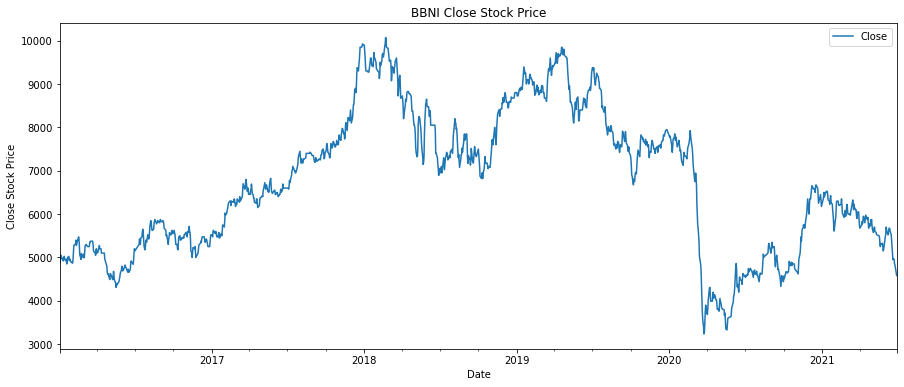

In [83]:
df[['Close']].plot(figsize=(15,6), title='BBNI Close Stock Price', ylabel='Close Stock Price');

### - Check Stationarity Data

In [84]:
# augmented dickey-fuller test function
def adfuller_test(series):
    """
    Pass time series, returns ADF report
    """
    print("Augmented Dickey-Fuller Test:")
    result = adfuller(series.dropna())
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[:4], index=labels)
    
    for key,val in result[4].items():
        output[f'critical value ({key})'] = val
    print(output.to_string())
    
    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Accept the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [85]:
# Cek stationary data close stock price
adfuller_test(df['Close'])

Augmented Dickey-Fuller Test:
ADF test statistic        -1.590630
p-value                    0.488299
# lags used                3.000000
# observations          2000.000000
critical value (1%)       -3.433624
critical value (5%)       -2.862986
critical value (10%)      -2.567540

Weak evidence against the null hypothesis
Accept the null hypothesis
Data has a unit root and is non-stationary


Data tidak stationer, maka dilakukan differencing agar data stationer

### - Differencing

In [86]:
# differencing
df['Close d1'] = diff(df['Close'], k_diff=1)     #lag 1

# Cek stationary data close stock price dengan differencing lag 1
adfuller_test(df['Close d1'])

Augmented Dickey-Fuller Test:
ADF test statistic       -22.801301
p-value                    0.000000
# lags used                2.000000
# observations          2000.000000
critical value (1%)       -3.433624
critical value (5%)       -2.862986
critical value (10%)      -2.567540

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Data mencapai stationary pada differincing lag 1. Dari informasi ini, untuk data close stock price akan digunakan parameter differencing ARIMA d=1 

### - Seasonality Data

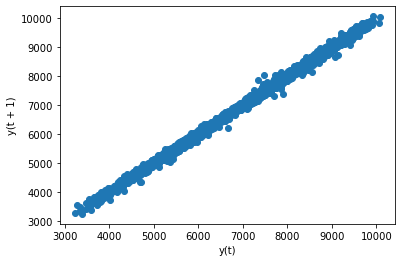

In [87]:
# Cek seasonality pada data menggunakan plot lag
lag_plot(df['Close']);

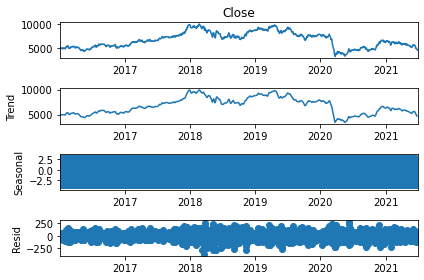

In [88]:
# Cek seasonality pada data menggunakan plot ETS (Error, Trend, Seasonality)
result = seasonal_decompose(df['Close'].dropna(), model='additive')
result.plot();

### - Autoregression (AR) Parameter

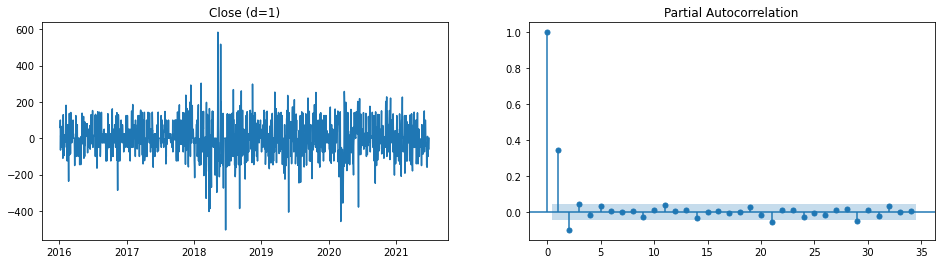

In [89]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Close'].diff().dropna())
ax1.set_title('Close (d=1)')
plot_pacf(df['Close'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai p term pada ARIMA. Pada model ini, akan digunakan p = 2 

### - Moving Average (MA) Parameter

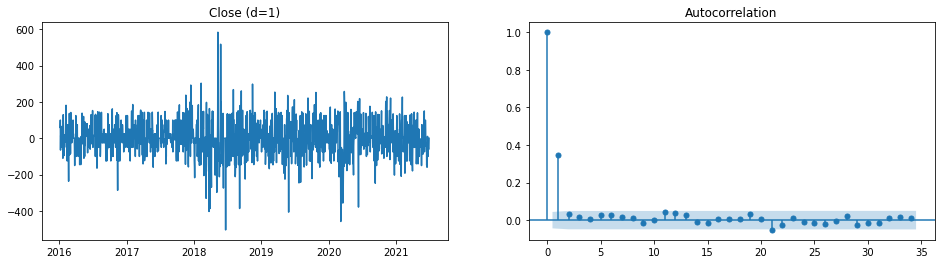

In [90]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(df['Close'].diff().dropna())
ax1.set_title('Close (d=1)')
plot_acf(df['Close'].diff().dropna(), ax=ax2);

Terlihat bahwa terdapat beberapa opsi lags yang berada di luar significant line sehingga dapat digunakan sebagai q term pada ARIMA. Pada model ini, akan digunakan q = 1 

### - Split Data

In [91]:
# split data, 2 bulan (60 hari) terakhir menjadi test set
train_data = df.iloc[:-60]
test_data = df.iloc[-60:]

### - ARIMA Model in Train Data

In [92]:
ARIMA_close = ARIMA(train_data['Close'], order=(2,1,1)).fit()
ARIMA_close.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1944
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -11336.767
Date:                Sun, 12 Dec 2021   AIC                          22681.534
Time:                        09:53:21   BIC                          22703.822
Sample:                    01-04-2016   HQIC                         22689.730
                         - 04-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0885      0.171     -0.517      0.605      -0.424       0.247
ar.L2          0.0625      0.070      0.893      0.372      -0.075       0.200
ma.L1          0.4714      0.168      2.798      0.005       0.141       0.802
sigma2      6853.4223    150.076     45.666      0.000    6559.279    7147.566
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               614.22
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Predictions in Test Data

In [93]:
# prediksi 2 bulan kedepan (test data)
start = len(train_data)
end = len(train_data)+len(test_data)-1

prediction_test = ARIMA_close.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,1) Test Prediction')
prediction_test

2021-05-01    5667.965183
2021-05-02    5665.003477
2021-05-03    5661.135679
2021-05-04    5661.292825
2021-05-05    5661.037199
2021-05-06    5661.069639
2021-05-07    5661.050793
2021-05-08    5661.054488
2021-05-09    5661.052983
2021-05-10    5661.053347
2021-05-11    5661.053221
2021-05-12    5661.053255
2021-05-13    5661.053244
2021-05-14    5661.053247
2021-05-15    5661.053246
2021-05-16    5661.053246
2021-05-17    5661.053246
2021-05-18    5661.053246
2021-05-19    5661.053246
2021-05-20    5661.053246
2021-05-21    5661.053246
2021-05-22    5661.053246
2021-05-23    5661.053246
2021-05-24    5661.053246
2021-05-25    5661.053246
2021-05-26    5661.053246
2021-05-27    5661.053246
2021-05-28    5661.053246
2021-05-29    5661.053246
2021-05-30    5661.053246
2021-05-31    5661.053246
2021-06-01    5661.053246
2021-06-02    5661.053246
2021-06-03    5661.053246
2021-06-04    5661.053246
2021-06-05    5661.053246
2021-06-06    5661.053246
2021-06-07    5661.053246
2021-06-08  

### - Model Evaluation

In [94]:
# rmse
error_rmse = rmse(test_data['Close'], prediction_test)
print(f'ARIMA(2,1,1) RMSE Error: {error_rmse:11.10}')
# mae
error_mae = mean_absolute_error(test_data['Close'], prediction_test)
print(f'ARIMA(2,1,1) MAE Error: {error_mae:11.10}')
# aic
aic_values = ARIMA_close.aic
print(f'ARIMA(2,1,1) AIC: {aic_values:6.5}')

ARIMA(2,1,1) RMSE Error: 433.8591462
ARIMA(2,1,1) MAE Error: 311.0304928
ARIMA(2,1,1) AIC: 2.2682e+04


In [95]:
# perbandingan rata-rata close stock price 2 bulan kedepan antara predicted dan actual
print("Rata-rata Close stock price actual:", test_data['Close'].mean())
print("Rata-rata Close stock price predicted:", prediction_test.mean())

Rata-rata Close stock price actual: 5354.21196090609
Rata-rata Close stock price predicted: 5661.239631797304


Rata-rata predicted mendekati rata-rata actual. Setelah mengetahui evaluasi model, maka perlu dilakukan training model kembali di keseluruhan dataset.

### - ARIMA Model on Full Dataset

In [96]:
ARIMA_close = ARIMA(df['Close'], order=(2,1,1)).fit()
ARIMA_close.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2004
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -11671.071
Date:                Sun, 12 Dec 2021   AIC                          23350.141
Time:                        09:53:21   BIC                          23372.551
Sample:                    01-04-2016   HQIC                         23358.369
                         - 06-29-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0845      0.170     -0.497      0.620      -0.418       0.249
ar.L2          0.0647      0.070      0.925      0.355      -0.072       0.202
ma.L1          0.4703      0.168      2.807      0.005       0.142       0.799
sigma2      6745.6611    144.908     46.551      0.000    6461.646    7029.676
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               640.33
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### - Forecasting The Future Value
Predict close stock price for the next 6 months

In [97]:
# start dan end prediksi (6 bulan = 182 hari)
start = len(df)
end = len(df) + 182-1

forecast = ARIMA_close.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,1,1) Open Stock Price Forecast')
forecast

2021-06-30    4584.452151
2021-07-01    4584.075956
2021-07-02    4584.395899
2021-07-03    4584.344516
2021-07-04    4584.369565
                 ...     
2021-12-24    4584.365818
2021-12-25    4584.365818
2021-12-26    4584.365818
2021-12-27    4584.365818
2021-12-28    4584.365818
Freq: D, Name: ARIMA(2,1,1) Open Stock Price Forecast, Length: 182, dtype: float64

In [98]:
# save model
ARIMA_close.save('model_bni_close.pkl')